# Olfaction Model Demo

This notebook illustrates how to run a Neurokernel-based model of part of the fruit fly's antennal lobe.

### Background

The early olfactory system in *Drosophila* consists of two antennal lobes,
one on each side of the fly brain. Each of these LPUs contain 49 glomeruli that
differ in functionality, size, shape, and relative position.  Each glomerulus
receives axons from about 50 olfactory receptor neurons (ORNs) on each of the
fly's two antennae that express the same odorant receptor. The axons of each ORN
connect to the dendrites of 3 to 5 projection neurons (PNs) in the glomeruli.
In addition to the PNs - which transmit olfactory information to the higher
regions of the brain - the antennal lobes contain local neurons (LNs) whose
connections are restricted to the lobes; inter-glomerular connectivity therefore
subsumes synaptic connections between ORNs and PNs, ORNs and LNs, LNs and PNs, and feedback
from PNs to LNs. The entire early olfactory system in *Drosophila*
contains approximately 4000 neurons.

The current model of the each antennal lobe comprises 49 glomerular channels
with full intraglomerular connectivity in both hemispheres of the fly brain. The
entire model comprises 2800 neurons, or 70% of the fly's entire antennal
lobe. All neurons in the system are modeled using the Leaky Integrate-and-Fire
(LIF) model and all synaptic currents elicited by spikes are modeled using alpha functions.
Parameters for 24 of the glomerular channels are based upon currently available
ORN type data [(Hallem et al., 2006)](#hallem_coding_2006); all other channels are configured with
artificial parameters.

A script that generates a [GEXF](http://gexf.net) file containing the antennal lobe model configuration is included in the ``examples/olfaction/data`` subdirectory of the Neurokernel source code. 

### Executing the Model

Assuming that the Neurokernel source has been cloned to `~/neurokernel`, we first generate an input signal of duration 1.0 seconds and construct the LPU configuration:

In [1]:
%cd -q ~/neurokernel/examples/olfaction/data
%run gen_olf_input.py
%run create_olf_gexf.py

Next, we identify the indices of the olfactory sensory neurons (OSNs) and projection neurons (PNs) associated with a specific glomerulus; in this case, we focus on glomerulus DA1:

In [2]:
import re
import networkx as nx
import neurokernel.tools.graph

g = nx.read_gexf('antennallobe.gexf.gz')
df_node, df_edge = neurokernel.tools.graph.graph_to_df(g)
glom_name = 'DA1'
osn_ind = sorted(list(set([ind[0] for ind in \
                           df_edge[df_edge.name.str.contains('.*-%s_.*' % glom_name)].index])))
pn_ind = sorted(list(set([ind[1] for ind in \
                          df_edge[df_edge.name.str.contains('.*-%s_.*' % glom_name)].index])))

# Get OSN and PN label indices:
osn_ind_labels = [int(re.search('osn_.*_(\d+)', name).group(1)) \
                  for name in df_node.ix[osn_ind].name]
pn_ind_labels = [int(re.search('.*_pn_(\d+)', name).group(1)) \
                 for name in df_node.ix[pn_ind].name]

We now execute the model:

In [3]:
%cd -q ~/neurokernel/examples/olfaction
%run olfaction_demo.py

Next, we display the input odorant concentration profile and the spikes produced by the 25 OSNs and 3 PNs associated with glomerulus DA1 in the model:

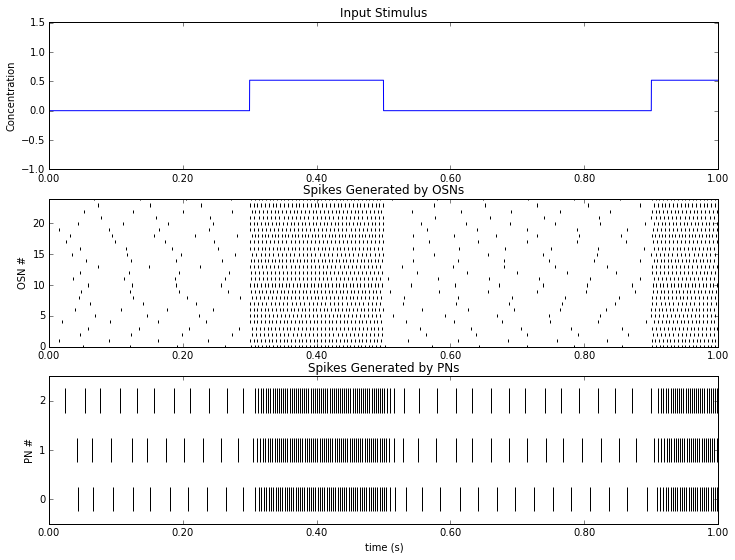

In [4]:
%matplotlib inline

import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

fmt = lambda x, pos: '%2.2f' % (float(x)/1e4)
with h5py.File('./data/olfactory_input.h5', 'r') as fi, \
    h5py.File('olfactory_output_spike.h5','r') as fo:
    data_i = fi['array'].value
    data_o = fo['array'].value 
mpl.rcParams['figure.dpi'] = 120 
mpl.rcParams['figure.figsize'] = (12,9)

raster = lambda data: plt.eventplot([np.nonzero(data[i, :])[0] for i in xrange(data.shape[0])],
                                    colors = [(0, 0, 0)],
                                    lineoffsets = np.arange(data.shape[0]),
                                    linelengths = np.ones(data.shape[0])/2.0)
f = plt.figure()
plt.subplot(311)
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(fmt))
plt.plot(data_i[:10000, 0]); 
ax.set_ylim(np.min(data_i)-1, np.max(data_i)+1)
ax.set_xlim(0, 10000)
plt.title('Input Stimulus'); plt.ylabel('Concentration') 

plt.subplot(312)
raster(data_o.T[osn_ind, :])
plt.title('Spikes Generated by OSNs'); plt.ylabel('OSN #');
ax = plt.gca()
ax.set_ylim(np.min(osn_ind_labels), np.max(osn_ind_labels))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(fmt))
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=5.0))

plt.subplot(313)
raster(data_o.T[pn_ind, :])
plt.title('Spikes Generated by PNs'); plt.ylabel('PN #');
ax = plt.gca()
ax.set_ylim(np.min(pn_ind_labels)-0.5, np.max(pn_ind_labels)+0.5)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(fmt))
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=1.0))

plt.xlabel('time (s)')

plt.subplots_adjust()
f.savefig('olfactory_output.png')

### Acknowledgements

The olfactory model demonstrated in this notebook was developed by Chung-Heng Yeh.

### References

<a name="hallem_coding_2006"></a>Hallem, E. A. and Carlson, J. R. (2006), Coding of odors by a receptor repertoire, Cell, 125, 1, 143–160, doi:10.1016/j.cell.2006.01.050